# HRRR Model Downloader Sample Notebook

This notebook provides some examples of downloading, processing, and working with hrrr data for visualizations and analysis.

### Imports and Setup

In [82]:
from herbie import Herbie, FastHerbie, wgrib2
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geojson
import xoak
import cartopy.feature as cfeature
import dask.array as da
import glob
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cfgrib
from matplotlib import pyplot as plt

### Helper Functions

In [83]:
# Takes a dict of vars you want to extract, and the corresponding granularities
# Uses XARRAY accessors to limit them
def download_parameters(parameters: dict, fh: FastHerbie) -> None:
    fields = [f":{param}:{level}" for param, level in parameters.items()]
    param_regex = fr"^(?:{'|'.join(fields)})"
    print("Search String: " + param_regex)
    return fh.download(param_regex)
    

In [84]:
# Parse GeoJson polygon - see skagit_boundaries.json for example
def parseGeoJson(geojson_path: str) -> tuple[float, float, float, float]:
    mask = gpd.read_file(geojson_path)
    minLon, minLat, maxLon, maxLat = mask.total_bounds
    return (minLon, maxLon, minLat, maxLat)

def limitGeographicRange(bounds: tuple[float, float, float, float], subsetFiles: list) -> list:
    return [wgrib2.region(f, bounds, name='skagit-basin') for f in subsetFiles]
            

### Parameter Selection and download files

In [85]:
model = 'hrrr' # Use HRRR Model
product = 'sfc' # Use 2D surface level fields; 3-km resolution; 1 hr intervals
date_range = pd.date_range(
    start="2020-03-01 00:00",
    end="2020-03-02 00:00",
    freq="1h"
)

# Parameter Names scoped from here: 
# https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfsfcf00.grib2.shtml
# See https://github.com/blaylockbk/Herbie/discussions/10
# for modifications to accumulated precip to get hourly amount
parameters = {
    'TMP' : 'surface', # Temperature - Hourly
    'RH' : '2 m above ground', # Relative Humidity - Hourly
    'WIND': '10 m above ground', # Wind Speed - 0-0 day max f 
    'APCP': 'surface:0-1 hour acc fcst', # Total Precip - 0-0 day acc f 
    'DSWRF': 'surface', # Downward Short-Wave Radiation Flux - Hourly
    'DLWRF': 'surface' # Downward Long-Wave Rad. Flux - Hourly
}

# Download files
fh = FastHerbie(date_range, model=model, product=product, fxx=range(0,2), save_dir="../data/weather_data/")
fh_files = download_parameters(parameters, fh)

Search String: ^(?::TMP:surface|:RH:2 m above ground|:WIND:10 m above ground|:APCP:surface:0-1 hour acc fcst|:DSWRF:surface|:DLWRF:surface)


### Create Inventory files to appease wgrib2, and then geolimit them based on boundaries file

In [86]:
# for f in fh_files:
#     wgrib2.create_inventory_file(f)

mask = gpd.read_file('../data/GIS/SkagitRiver_BasinBoundary.json')
bounds = parseGeoJson('../data/GIS/SkagitRiver_BasinBoundary.json')
geo_limited_files = limitGeographicRange(bounds, fh_files)

In [87]:
geo_limited_files

[PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_1aefe46d__hrrr.t00z.wrfsfcf00.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_1ae43e52__hrrr.t00z.wrfsfcf01.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_3fefe46d__hrrr.t01z.wrfsfcf00.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_3fe43e52__hrrr.t01z.wrfsfcf01.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_28efe46d__hrrr.t02z.wrfsfcf00.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_28e43e52__hrrr.t02z.wrfsfcf01.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_70efe46d__hrrr.t03z.wrfsfcf00.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_70e43e52__hrrr.t03z.wrfsfcf01.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301/skagit-basin_subset_47efe46d__hrrr.t04z.wrfsfcf00.grib2'),
 PosixPath('../data/weather_data/hrrr/20200301

### Load files, combine into xarray, and save as zarr

In [88]:
datasets = []
dropVars = ["surface", "heightAboveGround", "valid_time", "step"]
# if f001, grab just the accumlated precip by dropping the other forecast variables
dropVarsStep = dropVars + ["t", "r2", "si10", "sdswrf", "sdlwrf"]
for f in geo_limited_files:
    unMergedDatasets = cfgrib.open_datasets(f, indexpath='')
    mergedDataset = xr.merge([ds.drop_vars(dropVarsStep, errors="ignore") if ds.step.values == np.timedelta64(1, 'h') else ds.drop_vars(dropVars, errors="ignore") for ds in unMergedDatasets])
    mergedDataset.load()
    datasets.append(mergedDataset)

other = [ds for ds in datasets if 'tp' not in ds.variables]
tp = [ds for ds in datasets if 'tp' in ds.variables]

tp_ds = xr.concat(tp, dim='time')
other = xr.concat(other, dim='time')
comb = xr.combine_by_coords([tp_ds, other])
# Set Longitude to be in correct space
comb['longitude'] = comb.longitude-360

Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_1aefe46d__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_1ae43e52__hrrr.t00z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_3fefe46d__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_3fe43e52__hrrr.t01z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_28efe46d__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_28e43e52__hrrr.t02z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '../data/weather_data/hrrr/20200301/skagit-basin_subset_70efe46d__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GR

In [89]:
from shapely import vectorized

skagit_mask = vectorized.contains(mask.geometry[0], comb.longitude.values, comb.latitude.values)
skagit_mask

masked_data_set = comb.where(skagit_mask)
masked_data_set

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 25, y: 60, x: 54)
Coordinates:
  * time       (time) datetime64[ns] 200B 2020-03-01 ... 2020-03-02
    latitude   (y, x) float64 26kB 47.69 47.7 47.71 47.72 ... 49.56 49.56 49.57
    longitude  (y, x) float64 26kB -122.2 -122.2 -122.2 ... -120.9 -120.8 -120.8
Dimensions without coordinates: y, x
Data variables:
    si10       (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
    r2         (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
    t          (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
    sdswrf     (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
    sdlwrf     (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
    tp         (time, y, x) float32 324kB nan nan nan nan ... nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [90]:
zarr_path = '../data/weather_data/hrr.zarr'
masked_data_set.to_zarr(zarr_path,  mode='w')

### Load and Plot/Graph

In [91]:
data_zarr = xr.open_zarr(zarr_path)
data_zarr.unify_chunks()

<xarray.Dataset> Size: 2MB
Dimensions:    (y: 60, x: 54, time: 25)
Coordinates:
    latitude   (y, x) float64 26kB dask.array<chunksize=(60, 54), meta=np.ndarray>
    longitude  (y, x) float64 26kB dask.array<chunksize=(60, 54), meta=np.ndarray>
  * time       (time) datetime64[ns] 200B 2020-03-01 ... 2020-03-02
Dimensions without coordinates: y, x
Data variables:
    r2         (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
    sdlwrf     (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
    sdswrf     (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
    si10       (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
    t          (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
    tp         (time, y, x) float32 324kB dask.array<chunksize=(13, 60, 54), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_edition:            2
    GRIB_subCentre:          0
    institution:             US National Weather Service - NCEP

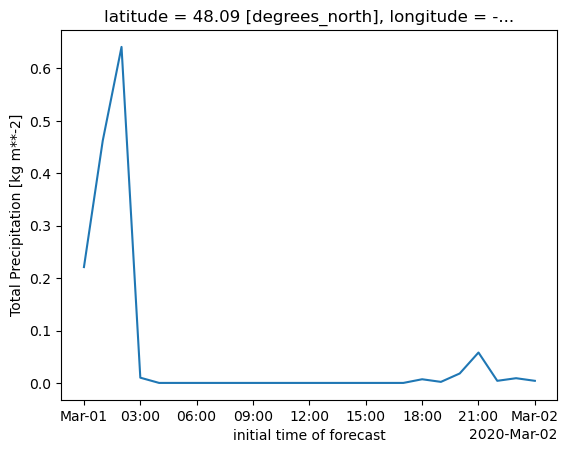

In [92]:
# Plot Glacier Peak Accumulated Precip per hour over period
gl_peak_lat_lon = xr.Dataset(
    {
        "lat": 	48.1048,
        "lon": -121.1124,
    }
)
import xoak

data_zarr.xoak.set_index(['longitude', 'latitude'], 'sklearn_geo_balltree')
data_zarr.xoak.sel(latitude=gl_peak_lat_lon.lat, longitude=gl_peak_lat_lon.lon).tp.sortby(data_zarr.time).plot()

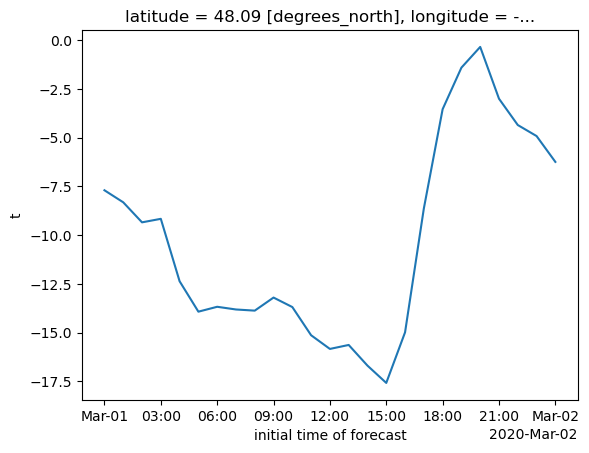

In [93]:
(data_zarr.xoak.sel(latitude=gl_peak_lat_lon.lat, longitude=gl_peak_lat_lon.lon).t - 273.15).sortby(data_zarr.time).plot()

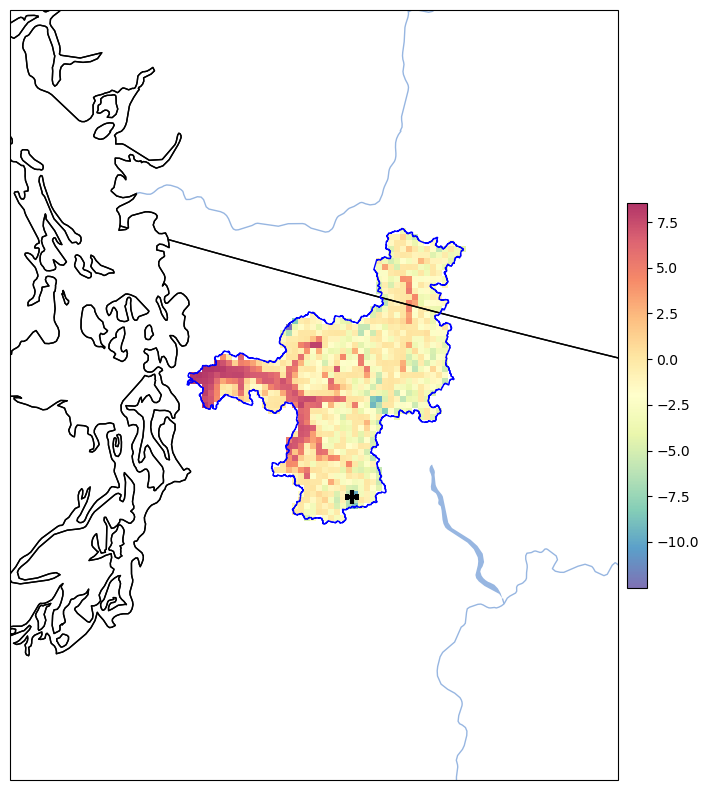

In [94]:
import cartopy.feature as cfeature
gl_peak_lat_lon = (48.1048, -121.1124)
lats = data_zarr.latitude
lons = data_zarr.longitude

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

# Plot temp at a certain hour/to
fig = plt.figure(figsize=[12, 10])
ax = plt.axes(projection=projection)
D = ax.pcolormesh(lons, lats, data_zarr.t.sel(time='2020-03-02T12:00', method='nearest')-273.15, transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(D, ax=ax, shrink=.5, pad=.01)
ax.scatter(gl_peak_lat_lon[1], gl_peak_lat_lon[0], transform=ccrs.PlateCarree(), marker='+', s=100, c='k', linewidth=3)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.set_extent([-120, -123, 47, 50], crs=ccrs.PlateCarree())
ax.add_geometries([mask.geometry[0]], ccrs.PlateCarree(), edgecolor='blue', facecolor='None')